In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import inspect, create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measure_table= Base.classes.measurement
station_table = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [11]:

inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

<Figure size 2160x1440 with 0 Axes>

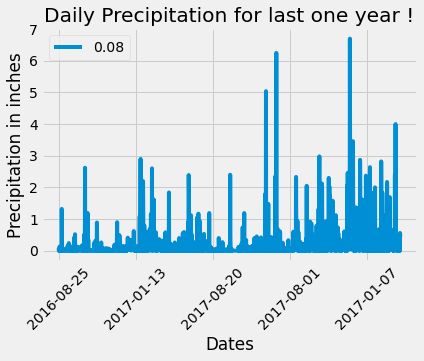

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data1 = session.query(measure_table.prcp,measure_table.date).order_by(measure_table.date.desc()).all()
data1
    
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measure_table.date).order_by(measure_table.date.desc()).first().date

last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(weeks=52)


# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(measure_table.date, measure_table.prcp).\
        filter(measure_table.date > last_year).all()


date_list = [each_row[0] for each_row in last_year_data]
prcp_list = [each_row[1] for each_row in last_year_data]
prcp_list = [float(str(data).replace('None','0')) for data in prcp_list]

 # Save the query results as a Pandas DataFrame and set the index to the date column
data2 = pd.DataFrame({'date':date_list, 'Total Precipitation':prcp_list})
data2
# Sort the dataframe by date
data2.sort_values('date')

# data2.groupby('date').sum()


plt.figure(figsize = (30,20))
# plt.bar(date_list, prcp_list)
data2.plot(x = 'date', y = 'Total Precipitation')
# plt.legend()
plt.title('Daily Precipitation for last one year !')
plt.xticks(rotation = 45)
plt.xlabel('Dates')
plt.ylabel('Precipitation in inches')
plt.legend(prcp_list)
plt.show()


In [18]:
# Design a query to show how many stations are available in this dataset?
query2 = session.query(measure_table.station).distinct().count()
query2
#Hence there are 9 stations in this dataset

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query3 = session.query(measure_table.station, func.count(measure_table.id), station_table.name).\
        filter(measure_table.station == station_table.station).\
        group_by(measure_table.station).order_by(func.count(measure_table.id).desc())
print('Station ID  ', '  Activity', 'Station Name')
for row in query3.all():
    print(row)
    
most_active = query3.first()[2]
most_active_id = query3.first()[0]
print('\n\nMost Active Station is : ',most_active)
print(most_active_id)

Station ID     Activity Station Name
('USC00519281', 2772, 'WAIHEE 837.5, HI US')
('USC00519397', 2724, 'WAIKIKI 717.2, HI US')
('USC00513117', 2709, 'KANEOHE 838.1, HI US')
('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US')
('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00517948', 1372, 'PEARL CITY, HI US')
('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')


Most Active Station is :  WAIHEE 837.5, HI US
USC00519281


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query4 = session.query(func.min(measure_table.tobs), func.max(measure_table.tobs), func.avg(measure_table.tobs)).\
        filter(measure_table.station == most_active_id).all()
query4

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.

query5 = session.query(measure_table.station, func.count(measure_table.tobs), station_table.name).\
        filter(measure_table.station == station_table.station).\
        group_by(measure_table.station).order_by(func.count(measure_table.tobs).desc())

print('Station ID  ', '  Tobs', 'Station Name')
for row in query5.all():
    print(row)
    
most_tobs = query5.first()[2]
most_tobs_id = query3.first()[0]
print('\n\nStations with most number of temperature observations is : ',most_tobs)
print(most_tobs_id)

Station ID     Tobs Station Name
('USC00519281', 2772, 'WAIHEE 837.5, HI US')
('USC00519397', 2724, 'WAIKIKI 717.2, HI US')
('USC00513117', 2709, 'KANEOHE 838.1, HI US')
('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US')
('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00517948', 1372, 'PEARL CITY, HI US')
('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')


Most Active Station is :  WAIHEE 837.5, HI US
USC00519281


2017-08-18
2016-08-19 00:00:00


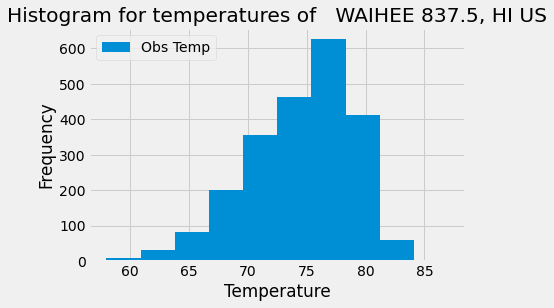

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(measure_table.date).order_by(measure_table.date.desc()).\
                    filter(measure_table.station == most_tobs_id).first().date
print(last_date)

last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(weeks=52)
print(last_year)

last_year_data = session.query(measure_table.date, measure_table.tobs).\
        filter(measure_table.date > last_year).all()
last_year_data

date_list = [each_data[0] for each_data in last_year_data]
tobs_list = [each_data[1] for each_data in last_year_data]
tobs_list

df= pd.DataFrame({'date':date_list, 'Obs Temp': tobs_list})
df.hist(legend = True)
plt.title(f'Histogram for temperatures of   {most_tobs}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
